In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oracle import Oracle
from accuracy_test import accuracy_check, accuracy_check_iter

In [2]:
def decentralizedSGD(x0, lr, max_iter, eps, W, oracle):
    
    x_t = x0
    x_prev = x0
    
    itr = 0
    error = np.inf
    current_sum = 0.
    
    errors = []
    
    while (itr < max_iter) and (error > eps):
         
        noise = np.random.normal(0, 1, size=x_t.shape)
        
        f, df = oracle(x_t + noise)
        
        x_prev = x_t
        
        y_t = x_t - lr * df
        x_t = y_t @ W
        
        if (oracle.getType() == "strongly convex") and (itr > 0):
            err, sum_ = accuracy_check_iter(x_prev, current_sum, itr, oracle, x_t)
            error = err
            current_sum = sum_
            errors.append(error)
        elif (oracle.getType() != "strongly convex"):
            err, sum_ = accuracy_check_iter(x_t, current_sum, itr, oracle)
            error = err
            current_sum = sum_
            errors.append(error)

        itr += 1
        
    return itr, errors

def MetropolisHastings(W):
    
    degrees = np.sum(W, axis=1)
    
    for i in range(W.shape[0]):
        for j in range(i, W.shape[0]):
            
            if W[i, j] != 0:
                
                weight = min(1 / (degrees[i] + 1), 1 / (degrees[j] + 1))
                
                W[i, j] = weight
                W[j, i] = weight
                
    return W


def toMatrix(n_nodes, adj_list):
    
    matrix = np.zeros((n_nodes, n_nodes))
    
    for node in adj_list:
        
        neighbors = adj_list[node]
        
        for neighbor in neighbors:
            
            matrix[node, neighbor] = 1
            matrix[neighbor, node] = 1
            
    return matrix.astype(np.float64)


def buildTopology(n_nodes, topology):
    
    if topology == "dense":
        
        W = np.ones((n_nodes, n_nodes))
        
        for i in range(n_nodes):
            W[i, i] = 0
            
        return MetropolisHastings(W.astype(np.float64))
    
    elif topology == "ring":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node == n_nodes - 1:
                connections[node] = [0]
            else:
                connections[node] = [node + 1]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "centralized":
        
        connections = {} # adjacency list
        
        for node in range(1, n_nodes):
            connections[node] = [0] # node 0 is central node
            
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    else:
        print("Wrong topology")
        

def experiment(list_nodes, n_params, topology, func_type, max_iter, lr, error_threshold):
    
    results = []
    #results_error = []
    
    for n_nodes in list_nodes:
        
        print("Starting experiment on {} nodes.".format(n_nodes))
        
        temp = []
        #temp_err = []
        
        for _ in range(5): # Do average
            
            x0 = np.ones((n_params, n_nodes)).astype(np.float64) #np.random.randn(n_params, n_nodes)
            W = buildTopology(n_nodes, topology)
            
            oracle = Oracle(func_type, n_params, n_nodes)

            itr, errors = decentralizedSGD(x0, lr, max_iter, error_threshold, W, oracle)

            temp.append(itr)
            #temp_err.append(errors)
        
        mean = np.mean(temp)
        #mean_err = np.mean(temp_err, axis=0)
        print("Converged within {} in {} iterations on average.".format(error_threshold, mean))
        print()
        
        results.append(mean)
        #results_error.append(mean_err)
    
    return np.array(results)#, np.array(results_error)
    

def plotIter(num_nodes, iters):
    
    plt.plot(num_nodes, iters)
    plt.xlabel("Number of nodes")
    plt.ylabel("Number of iterations")
    plt.show()

Starting experiment on 2 nodes.
Converged within 0.01 in 334.0 iterations on average.

Starting experiment on 22 nodes.
Converged within 0.01 in 10211.4 iterations on average.

Starting experiment on 42 nodes.
Converged within 0.01 in 20082.8 iterations on average.

Starting experiment on 62 nodes.
Converged within 0.01 in 29881.2 iterations on average.

Starting experiment on 82 nodes.
Converged within 0.01 in 39597.2 iterations on average.



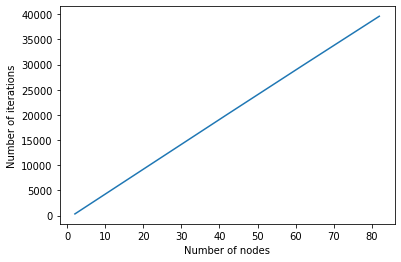

In [4]:
n_params = 10
topology = "dense"
func_type = "strongly convex"
max_iter = np.inf
lr = 1e-4
threshold = 1e-2

num_nodes = list(range(2, 100, 20))

results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold)

plotIter(num_nodes, results)